## HW3


In [1]:
# load packages
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from Utils import *
from scipy.optimize import linear_sum_assignment
from scipy import linalg
# from net_utils import getPatches

/scratch/wengchic/miniconda3/envs/hw1_new/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters setting
images_root = "Stereo_images"
kps_num = 100
patch_size = 32
feat_size = 128
keypoints = torch.zeros(5, 2,100, 2)
patches = torch.zeros(5, 2, 100, 1, 32, 32)
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create(600)

In [3]:
for i in range(5):
    imageA_path = images_root + "/image" +str(i+1) + str(1) + ".png"
    imageB_path = images_root + "/image" +str(i+1) + str(2) + ".png"
    
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)
    imgA= cv2.cvtColor(imageA,cv2.COLOR_BGR2GRAY)
    imgB= cv2.cvtColor(imageB,cv2.COLOR_BGR2GRAY)
    
    ## find the keypoints and descriptors with SIFT
    kps, des = sift.detectAndCompute(imgA, None)
    
    ## sort by response, and remove duplicate
    kps.sort(key=lambda x:x.response, reverse=True)
    temp = set()
    kps = [x for x in kps if x.pt not in temp and not temp.add(x.pt)]
    
    ## find the keypoints and descriptors with SIFT
    keypoints_img = [kps[a].pt for a in range(kps_num)][:kps_num]
    
    patches[i,0] = getPatches(keypoints_img, imgA, size=patch_size, num=kps_num) 
    keypoints[i,0] = torch.Tensor(keypoints_img)
    
    # repeat for imageB
    kps2, des2 = sift.detectAndCompute(imgB, None)
    ## sort by response, and remove duplicate
    kps2.sort(key=lambda x:x.response, reverse=True)
    temp2 = set()
    kps2 = [x for x in kps2 if x.pt not in temp2 and not temp2.add(x.pt)]
    
    keypoints_img2 = [kps2[a].pt for a in range(kps_num)][:kps_num]
    
    patches[i,1] = getPatches(keypoints_img2, imgB, size=patch_size, num=kps_num)
    keypoints[i,1] = torch.Tensor(keypoints_img2)

In [4]:
#load network
from descriptor_CNN3 import DesNet
model = DesNet()
model.cuda()
model.eval()
trained_weights = torch.load("checkpoint.pth")
model.load_state_dict(trained_weights["state_dict"])

<All keys matched successfully>

In [5]:
with torch.no_grad(): # only 3612MiB, without this line, it will be 9132MiB
    des = model(patches.view(-1, 1, patch_size, patch_size).cuda()).view(5, 2, kps_num, feat_size).data

In [6]:
print(keypoints.shape)
print(des.shape)

torch.Size([5, 2, 100, 2])
torch.Size([5, 2, 100, 128])


### Match the key points in each image pair using one2one matching algorithm

In [7]:
M0 = torch.zeros(5, 2, 50, 2)
F0 = torch.zeros(5, 3, 3)
F1 = torch.zeros(5, 3, 3)
for i in range(5):
    # calculate matching M0
    row_ind, col_ind = getCost_one2one(des[i, 0], des[i, 1], kps_num=100, topk=50)
    M0[i, 0] = keypoints[i,0][row_ind]
    M0[i, 1] = keypoints[i,1][col_ind]
    pts1 = M0[i, 0].numpy()
    pts2 = M0[i, 1].numpy()
    f0, _ = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
    F0[i] = torch.Tensor(f0)
    f1, _ = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)
    F1[i] = torch.Tensor(f1)

In [8]:
'''
Starting from the original 100 SIFT keypoint detections in image 1 and image 2, 
find another set of one-to-one matching pairs by combining both appearance and 
epipolar cues in matching, as formulated in slide 24 of 
lecture CS537_13.pdf: LaTeX: \text{minimize}\;\text{Trace}[(A+ \lambda B)^\top Y]minimize Trace [ ( A + λ B ) ⊤ Y ], subject to one-to-one constraints.
For computing matrix LaTeX: BB, as specified in slide 21 of lecture CS537_13.pdf, use LaTeX: F^{(1)}F ( 1 ) 
(remark: do not forget to use absolute values in LaTeX: BB, and normalize values of matrices LaTeX: AA and LaTeX: BB to 
fall in a similar range). Experimentally find a good value for the weighting parameter LaTeX: \lambda > 0λ > 0. 
From the matched pairs select the top 50 best matches 
LaTeX: M^{(1)}=\{({\bf p}_i, {\bf q}_{i'}): ~~i=1,\dots, 50,\;\;i'=1,\dots,50\}M ( 1 ) = { ( p i , q i ′ ) :     i = 1 , … , 50 , i ′ = 1 , … , 50 }. 
For matching, you may use either your own code or our solution for HW2.
'''
# get F2: Estimate the fundamental matrix LaTeX: F^{(2)}F ( 2 ) by
# implementing the RANSAC algorithm on LaTeX: M^{(1)}M ( 1 ), as suggested for LaTeX: F^{(1)}F ( 1 ).

cost1 = torch.zeros(5, 100, 100)
simi  = torch.zeros(5, 100, 100)
cost2 = torch.zeros(5, 100, 100)
similarity_one2one = torch.zeros(5)
M1 = torch.zeros(5, 2, 50, 2)
F2 = torch.zeros(5, 3, 3)
lamb = 10

for i in range(5):    
    des1 = des[i, 0]
    des2 = des[i, 1]
    kps1 = keypoints[i, 0]
    kps2 = keypoints[i, 1]
    cost1[i] = get_kps_pair_appearance_cost(des1, des2)
    cost2[i]= get_kps_pair_geometric_cost(kps1, kps2, F1[i])
    cost = cost1[i] + lamb * cost2[i]
    row_ind, col_ind = getCost_one2one_with_cost(cost, kps_num=100, topk=50)
    temp_total_cost = cost[row_ind, col_ind].sum()
    M1[i, 0] = keypoints[i,0][row_ind]
    M1[i, 1] = keypoints[i,1][col_ind]
    pts1 = M1[i, 0].numpy()
    pts2 = M1[i, 1].numpy()
    f2, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)
    F2[i] = torch.Tensor(f2)

In [9]:
## "fundamental.pth": 5 x 3 x 3 x 3 tensor consisting of your estimates of five 3x3 fundamental 
## matrices LaTeX: F^{(0)}F ( 0 ), LaTeX: F^{(1)}F ( 1 ), LaTeX: F^{(2)}F ( 2 ) for the five stereo image pairs.
fundamentals = torch.stack((F0, F1, F2), dim=1)


In [10]:
## (15 points) "epipoles.pth": 5 x 3 x 2 x 3 tensor consisting of your estimates of 
## five pairs of epipoles in image 1 and image 2 for 
## LaTeX: F^{(0)}F ( 0 ), LaTeX: F^{(1)}F ( 1 ), LaTeX: F^{(2)}F ( 2 ).
## get epipoles, need to solve svd
epipoles = torch.zeros(5, 3, 2, 3)
for i in range(5):
    for j in range(3):
        f = fundamentals[i, j]
        epi0 = epipoleSVD(f.numpy())                 # on image 0
        epi1 = epipoleSVD(f.permute(1,0).numpy())    # on image 1
        epi0 = torch.from_numpy(epi0)
        epi1 = torch.from_numpy(epi1)
        epipoles[i, j, 0] = epi0
        epipoles[i, j, 1] = epi1

## save results


In [11]:
# (60 points) "fundamental.pth": 5 x 3 x 3 x 3 tensor consisting of your estimates of five 3x3 fundamental matrices for the five stereo image pairs.
torch.save(fundamentals, "fundamental.pth")
# (15 points) "epipoles.pth": 5 x 3 x 2 x 3 tensor consisting of your estimates of five pairs of epipoles in image 1 and image 2 for LaTeX: F0, F1 and F2.
torch.save(epipoles, "epipoles.pth")

# save kps
torch.save(keypoints, "keypoints.pth")
# save path
torch.save(des, "des.pth")

# draw plots

In [1]:
# 1. Clearly mark one example point selected in image 1, and the three corresponding epipolar lines in image 2  
#    -- first for F0, second for F1, and third for F2 (use different colors for depicting the three epipolar lines), as illustrated in the figure below.
# 2. Clearly mark the epipoles of image 1 and image 2 for F0, F1, F2 (use different colors for depicting the three epipoles) if they fall inside the image boundaries.
# 3. In the figure caption specify: 
#     (a) the row and column of the point you selected in image 1; 
#     (b) comment if the three epipolar lines (closely) pass through the right corresponding point in image 2;  
#     (c) comment, based on your observation of the three epipolar lines in image 2, which estimate F0, F1, F2 is the best.
images_root = "Stereo_images"

fig = plt.figure(figsize=(15, 25))
for i in range(5):
    imageA_path = images_root + "/image" +str(i+1) + str(1) + ".png"
    imageB_path = images_root + "/image" +str(i+1) + str(2) + ".png"
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)
    
    F0 = fundamentals[i, 0]
    F1 = fundamentals[i, 1]
    F2 = fundamentals[i, 2]
    
    img1 = imageA
    img2 = imageB
    # select one point in image 1, you can use kpts from M0, M1, or M2
    kps0 = M0[i, 0, 0:1]
    # calculate its epipolar lines in image2
    lines0_F0 = cv2.computeCorrespondEpilines(kps0.numpy(), 2,F0.numpy())
    lines0_F1 = cv2.computeCorrespondEpilines(kps0.numpy(), 2,F1.numpy())
    lines0_F2 = cv2.computeCorrespondEpilines(kps0.numpy(), 2,F2.numpy())
    # draw kps0 on img1, and draw lines0s on img2
    img5, img6 = drawKptsLines(img1,img2,kps0[0], lines0_F0[0,0], lines0_F1[0,0], lines0_F2[0,0])
    ax1 = fig.add_subplot(5, 2, i*2+1)
    plt.title('Point: ({:d}, {:d})'.format(int(kps0[0][0]), int(kps0[0][1])))
    plt.tight_layout()
    plt.imshow(img5)
    ax2 = fig.add_subplot(5, 2, i*2+2)
    plt.title('Line0 = {:.5f} x +{:.5f}\nLine1 = {:.5f} x +{:.5f}\nLine2 = {:.5f} x +{:.5f}\n'.format(lines0_F0[0,0][0]/lines0_F0[0,0][2],lines0_F0[0,0][1]/lines0_F0[0,0][2],
                                                                                                  lines0_F1[0,0][0]/lines0_F1[0,0][2],lines0_F1[0,0][1]/lines0_F1[0,0][2],
                                                                                                  lines0_F2[0,0][0]/lines0_F2[0,0][2],lines0_F2[0,0][1]/lines0_F2[0,0][2],))
    plt.imshow(img6)

NameError: name 'plt' is not defined

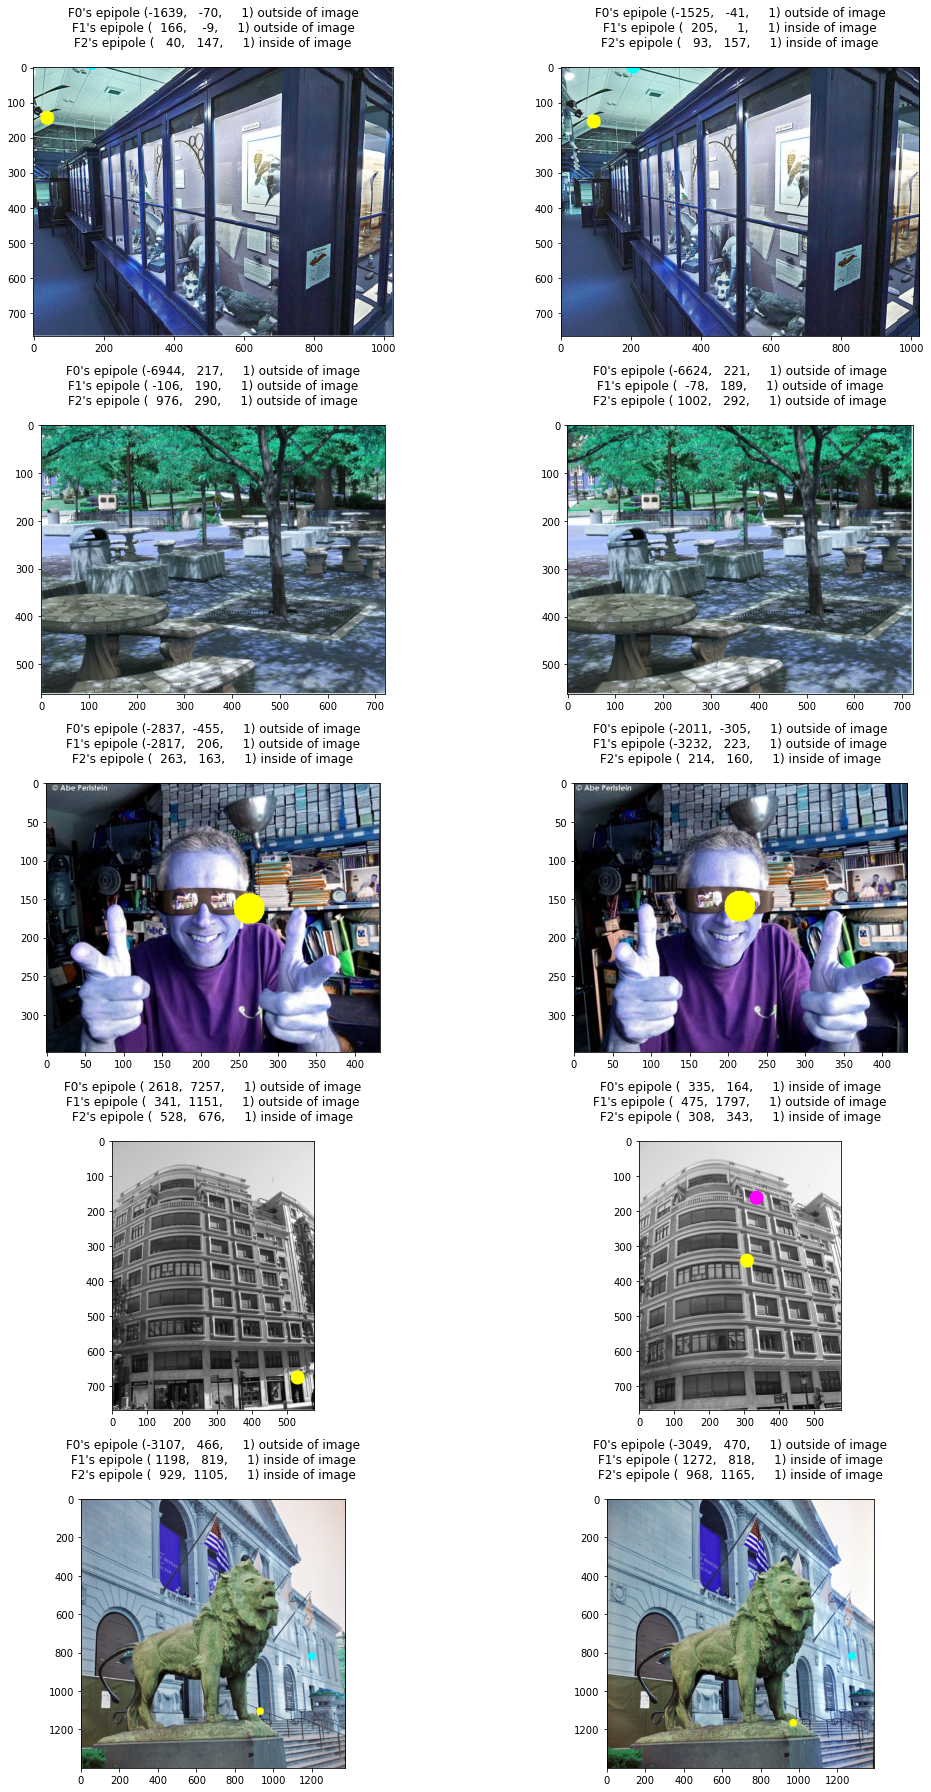

In [13]:
# 2. Clearly mark the epipoles of image 1 and image 2 for F0, F1, F2 (use different colors for depicting the three epipoles) if they fall inside the image boundaries.
fig = plt.figure(figsize=(15, 25))
for i in range(5):
    imageA_path = images_root + "/image" +str(i+1) + str(1) + ".png"
    imageB_path = images_root + "/image" +str(i+1) + str(2) + ".png"
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)
    h, w, c = imageA.shape
    colors = [(255, 0, 255), (0, 255, 255), (255, 255, 0)]
    capt1 = ""
    capt2 = ""
    for j in range(3):
        img1 = drawEpipoles(imageA, epipoles[i, j, 0, :2], colors[j])
        img2 = drawEpipoles(imageB, epipoles[i, j, 1, :2], colors[j])
        capt1 +=  "F{:d}'s epipole ({:5d}, {:5d}, {:5d}) ".format(j, int(epipoles[i, j, 0, 0]), int(epipoles[i, j, 0, 1]), int(epipoles[i, j, 1, 2]))
        capt2 +=  "F{:d}'s epipole ({:5d}, {:5d}, {:5d}) ".format(j, int(epipoles[i, j, 1, 0]), int(epipoles[i, j, 1, 1]), int(epipoles[i, j, 1, 2]))
        
        if 0 < epipoles[i, j, 0, 0] < w and 0 < epipoles[i, j, 0, 1] < h:
            capt1 +=  "inside of image\n"
        else:
            capt1 +=  "outside of image\n"
        
        if 0 < epipoles[i, j, 1, 0] < w and 0 < epipoles[i, j, 1, 1] < h:
            capt2 +=  "inside of image\n"
        else:
            capt2 +=  "outside of image\n"
            
    ax1 = fig.add_subplot(5, 2, i*2+1)
    plt.tight_layout()
    plt.title(capt1)
    plt.imshow(img1)
    ax2 = fig.add_subplot(5, 2, i*2+2)
    plt.title(capt2)
    plt.imshow(img2)